In [58]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import talib
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr, spearmanr
from statsmodels.regression.rolling import RollingOLS


import datetime
import time
import os
import pytz
import json
import csv

from pprint import pprint



In [2]:
# GLOBAL SETTINGS

# Data directories
#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
coin_dataDir = 'DATA/COMBINEDDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/'
model_dataDir = 'DATA/MODELDATA/'
riskFactor_dataDir = 'DATA/RISKFACTORSDATA/'



isdir = os.path.isdir(model_dataDir)

# Date ranges
START = 2020
END = 2022

MONTH = 30
YEAR = 12 * MONTH

# Helpers
idx = pd.IndexSlice
sns.set_style('whitegrid')

# END GLOBAL SETTINGS

In [3]:
# Read in MDF with initial coin pool
cpool_mdf = pd.read_csv(coin_dataDir + 'CoinPool.csv')
cpool_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
cpool_mdf['Dates'] = pd.to_datetime(cpool_mdf['Dates'])
cpool_mdf.set_index(['Dates', 'Coin'], inplace=True)
print('Initial Base Data:'.upper())
print(cpool_mdf.info())


ohlcv = ['Open','High','Low','Close','Volume']
prices_mdf = (cpool_mdf
              .loc[idx[str(START):str(END), :], ohlcv]
              .swaplevel()
              .sort_index())

# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker
nobs = prices_mdf.groupby(level='Coin').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices_mdf = prices_mdf.loc[idx[keep, :], :]
print("After dropping coins with less than 2 years of data".upper())
print(prices_mdf.info())

INITIAL BASE DATA:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 55894 entries, (Timestamp('2018-07-21 00:00:00'), 'basic-attention-token') to (Timestamp('2022-01-14 00:00:00'), 'zcash')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        55894 non-null  float64
 1   High        55894 non-null  float64
 2   Low         55894 non-null  float64
 3   Close       55894 non-null  float64
 4   Volume      55894 non-null  float64
 5   Market Cap  55894 non-null  float64
dtypes: float64(6)
memory usage: 2.8+ MB
None
AFTER DROPPING COINS WITH LESS THAN 2 YEARS OF DATA
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30522 entries, ('algorand', Timestamp('2020-01-01 00:00:00')) to ('zcash', Timestamp('2022-01-14 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    30522 non-null  float64
 1   High    30522 non-null  float64
 2   Low    

In [4]:
# Compute Technical Analysis Indicators to be use as momentum alpha factors

# Relative Strength Index (RSI)
prices_mdf['RSI'] = prices_mdf.groupby(level='Coin').Close.apply(talib.RSI)

# Bollinger Bands
def compute_bb(close):
    high, mid, low = talib.BBANDS(close, timeperiod=20)
    return pd.DataFrame({'BB_high': high, 'BB_low': low}, index=close.index)

prices_mdf = (prices_mdf.join(prices_mdf
                      .groupby(level='Coin')
                      .Close
                      .apply(compute_bb)))

# Average True Range (ATR)
def compute_atr(coin_data):
    df = talib.ATR(coin_data.High, coin_data.Low,
             coin_data.Close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices_mdf['ATR'] = (prices_mdf.groupby('Coin', group_keys=False)
                 .apply(compute_atr))

# Moving Average Convergence Divergence (MACD)
def compute_macd(close):
    macd = talib.MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices_mdf['MACD'] = (prices_mdf
                  .groupby('Coin', group_keys=False)
                  .Close
                  .apply(compute_macd))


# Stochastic Oscillator (STOCH)
def compute_stoch(coin_data):
    slowk, slowd = talib.STOCH(coin_data.High,
                         coin_data.Low,
                         coin_data.Close,
                         fastk_period=14,
                         slowk_period=3,
                         slowk_matype=0,
                         slowd_period=3,
                         slowd_matype=0)

    return slowd/slowk

prices_mdf['STOCH'] = (prices_mdf
                       .groupby('Coin', group_keys=False)
                       .apply(compute_stoch))

# Average Directional Index (ADX)
def compute_adx(coin_data):
    real = talib.ADX(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

prices_mdf['ADX'] = (prices_mdf
                     .groupby('Coin', group_keys=False)
                     .apply(compute_adx))


#Plus/Minus Directional Index
def compute_diplus(coin_data):
    real = talib.PLUS_DI(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

def compute_diminus(coin_data):
    real = talib.MINUS_DI(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

prices_mdf["DI_PLUS"] = (prices_mdf.groupby('Coin', group_keys=False).apply(compute_diplus))
prices_mdf["DI_MINUS"] = (prices_mdf.groupby('Coin', group_keys=False).apply(compute_diminus))

# Compute lagged returns and Winsorize
lags = [1, 7, 14, 30, 60, 90]
q = 0.0001

for lag in lags:
    prices_mdf[f'return_{lag}d'] = (prices_mdf.groupby(level='Coin').Close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )
# Shift lagged returns
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 7, 14, 30, 60, 90]:
        prices_mdf[f'return_{lag}d_lag{t}'] = (prices_mdf.groupby(level='Coin')
                                           [f'return_{lag}d'].shift(t * lag))

# Generate target forward returns
for t in [1, 7, 14, 30, 60, 90]:
    prices_mdf[f'target_{t}d'] = prices_mdf.groupby(level='Coin')[f'return_{t}d'].shift(-t)

# Create dummy time variables. USe drop first to avoid creating multicollinearity.
prices_mdf['year'] = prices_mdf.index.get_level_values('Dates').year
prices_mdf['month'] = prices_mdf.index.get_level_values('Dates').month

prices_mdf = pd.get_dummies(prices_mdf,
                        columns=['year', 'month'],
                        prefix=['year', 'month'],
                        prefix_sep=['_', '_'],
                        drop_first=True)


# Read in PCA Risk Factors
risk_factors_df = pd.read_csv(riskFactor_dataDir + 'PCA_Risk_Factors.csv')
risk_factors_df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
risk_factors_df['Dates'] = risk_factors_df['Dates'].astype('datetime64')
risk_factors_df = risk_factors_df.set_index('Dates')
risk_factors_df.drop(risk_factors_df.index[-1], inplace=True)

# Combine them with daily returns
daily_returns = prices_mdf.loc[:, 'return_1d':'return_90d']
factor_betas = daily_returns.join(risk_factors_df).sort_index()

# Get rid of the extra returns
del factor_betas['return_7d']
del factor_betas['return_14d']
del factor_betas['return_30d']
del factor_betas['return_60d']
del factor_betas['return_90d']

# Compute the factor Betas with Rolling OLS Regression on the PCA Principal Componenets
T = 30
betas = (factor_betas.groupby(level='Coin',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1d,
                                     exog=sm.add_constant(x.drop('return_1d', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))


factors = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3',
           'Principal Component 4', 'Principal Component 5', 'Principal Component 6']

# Impute missing Betas
betas = betas.loc[:, factors] = betas.groupby('Coin')[factors].apply(lambda x: x.fillna(x.mean()))
print("Factos Betas:".upper())
print(betas.describe().join(betas.sum(1).describe().to_frame('total')))

# Combine the Factor Betas with the rest of the model
prices_mdf = (prices_mdf
        .join(betas
              .groupby(level='Coin')
              .shift()))

# Immpute the missing factor betas to fill things out
prices_mdf.loc[:, factors] = prices_mdf.groupby('Coin')[factors].apply(lambda x: x.fillna(x.mean()))
print("Features so far".upper())
print(prices_mdf.columns)

FACTOS BETAS:
       Principal Component 1  Principal Component 2  Principal Component 3  \
count           30522.000000           30522.000000           30522.000000   
mean                0.167969               0.022483               0.001269   
std                 0.064366               0.222865               0.224443   
min                -0.373649              -1.650215              -1.225130   
25%                 0.130986              -0.054267              -0.117952   
50%                 0.167063              -0.011040              -0.039828   
75%                 0.202442               0.044471               0.064639   
max                 0.722359               2.383759               1.747162   

       Principal Component 4  Principal Component 5  Principal Component 6  \
count           30522.000000           30522.000000           30522.000000   
mean                0.014609              -0.015690              -0.017230   
std                 0.226748               0.2414

In [5]:
# Save the model data
if isdir == False:
    os.makedirs(model_dataDir)
    print("Directory '% s' created" % model_dataDir)
    prices_mdf.to_hdf(f'{model_dataDir}model_data.h5', 'model_data')
    prices_mdf.to_csv(f'{model_dataDir}ModelData.csv')
    print(f"The model data has been saved to {model_dataDir} as a MultiIndex dataframe")

else:
    prices_mdf.to_csv(f'{model_dataDir}ModelData.csv')
    prices_mdf.to_hdf(f'{model_dataDir}model_data.h5', 'model_data')
    print(f"The model data has been saved to {model_dataDir} as a MultiIndex dataframe")



The model data has been saved to DATA/MODELDATA/ as a MultiIndex dataframe


Coins with Unique Values:
41


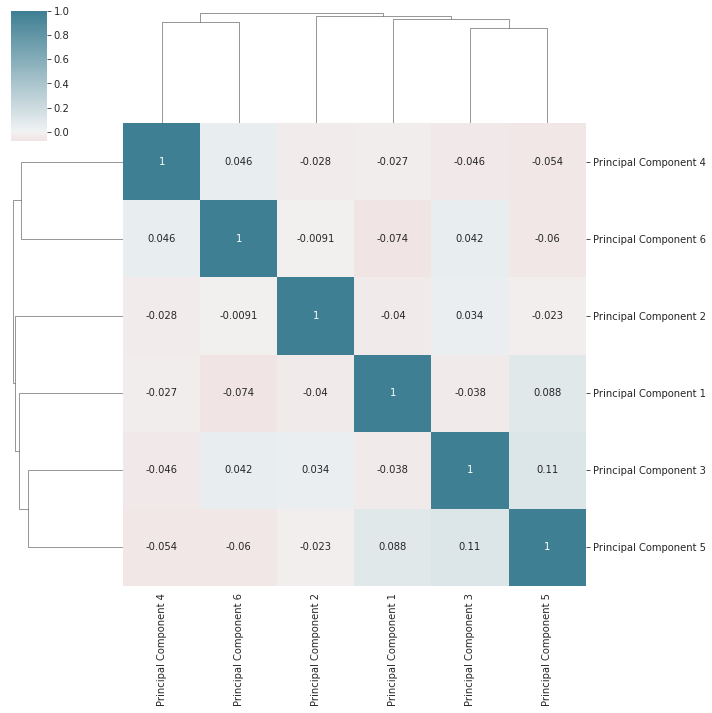

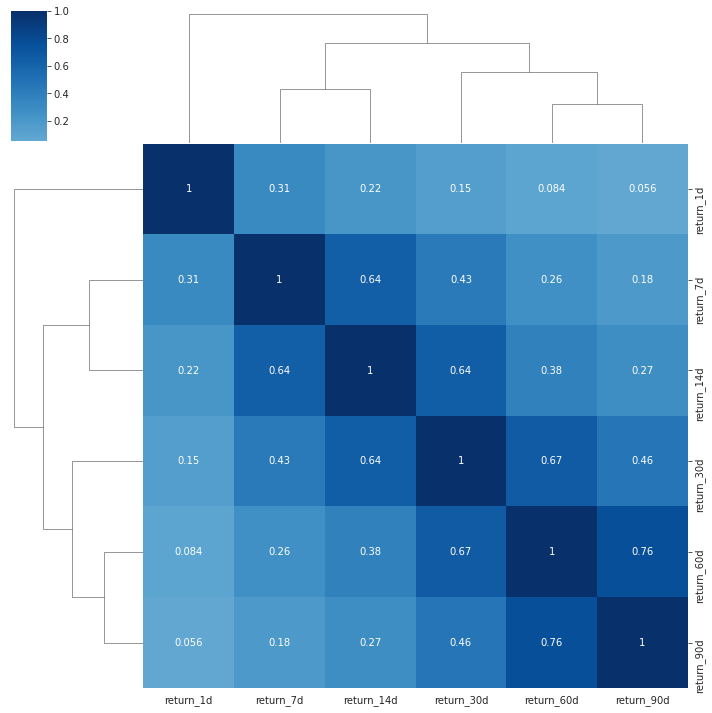

In [6]:
# DATASET INSIGHTS AND VISUALIZATION PLOTS

# Plot correlation custermap of the Betas
cmap = sns.diverging_palette(10, 220, as_cmap=True)
beta_cmap = sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

# Correlation Cluster map of the Returns
returns = prices_mdf.loc[:, 'return_1d':"return_90d"]
clusterMap = sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap='Blues')
print('Coins with Unique Values:')
print(returns.index.get_level_values('Coin').nunique())



/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


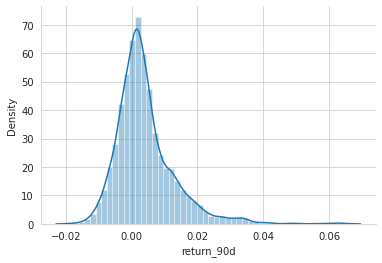

In [7]:
# Check return distributions

sns_distPlot = sns.distplot(returns['return_90d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


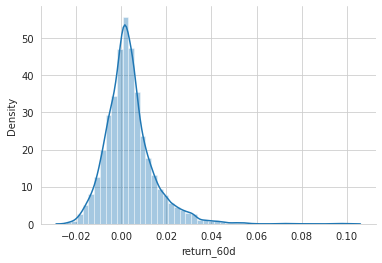

In [8]:
sns_distPlot = sns.distplot(returns['return_60d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


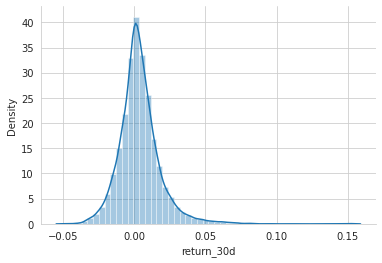

In [9]:
sns_distPlot = sns.distplot(returns['return_30d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


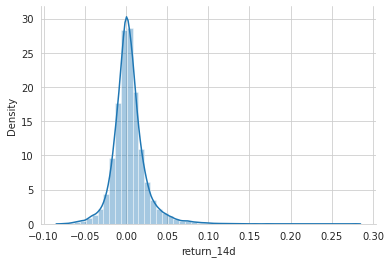

In [10]:
sns_distPlot = sns.distplot(returns['return_14d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


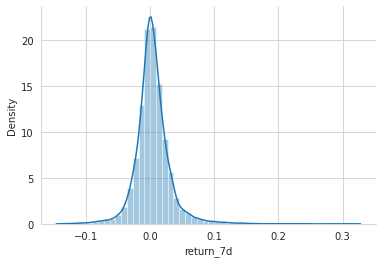

In [11]:
sns_distPlot = sns.distplot(returns['return_7d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


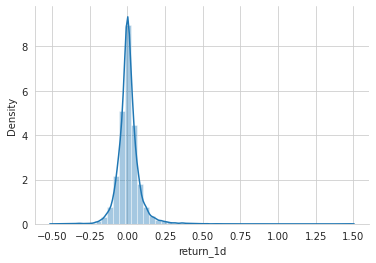

In [12]:
sns_distPlot = sns.distplot(returns['return_1d'])
fig = sns_distPlot.get_figure()
sns.despine()

Daily Returns Spearman
-8.96% (0.00%)


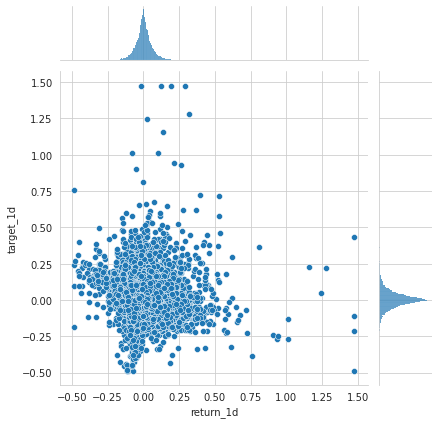

In [13]:
# Spearman Ranks and scatter plots for factors
target = 'target_7d'
price_copy = prices_mdf.copy()

# Daily Returns
daily_target = "target_1d"
metric = 'return_1d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Daily Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')


Weekly Returns Spearman
0.89% (12.47%)


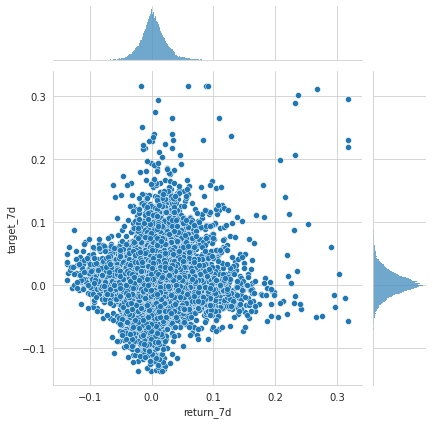

In [14]:
# Weekly Returns
daily_target = "target_7d"
metric = 'return_7d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Weekly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Bi-Weekly Returns Spearman
6.72% (0.00%)


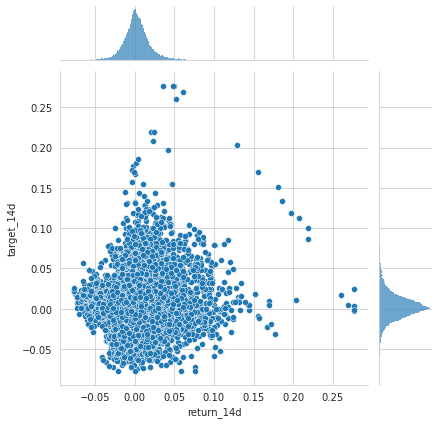

In [15]:
# Bi-Weekly Returns
daily_target = "target_14d"
metric = 'return_14d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Bi-Weekly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Monthly Returns Spearman
2.44% (0.00%)


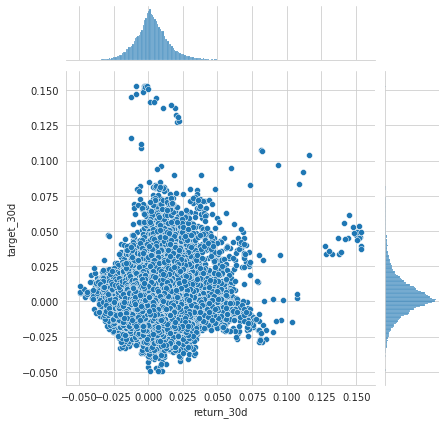

In [16]:
# Monthly Returns
daily_target = "target_30d"
metric = 'return_30d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Monthly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Bi-Monthly Returns Spearman
-11.14% (0.00%)


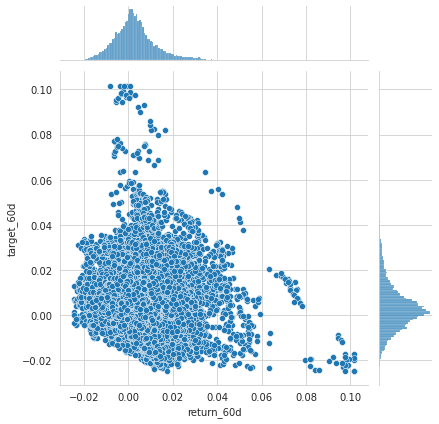

In [17]:
# Bi-Monthly Returns
daily_target = "target_60d"
metric = 'return_60d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Bi-Monthly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Three Month Returns Spearman
-33.32% (0.00%)


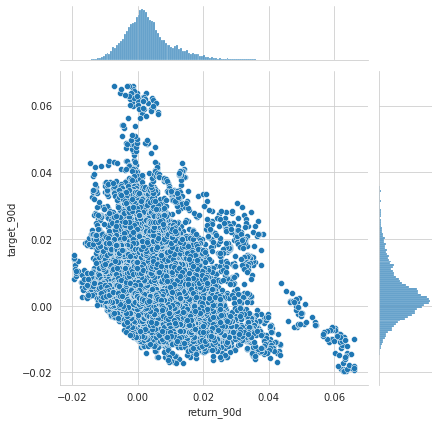

In [18]:
# Three Month Returns
daily_target = "target_90d"
metric = 'return_90d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Three Month Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Daily RETURNS FEATURE INFO
RSI Distributions
              count      mean       std       min       25%       50%       75%       max
rsi_signal                                                                               
(0, 30]       493.0  0.010035  0.026166 -0.088512 -0.002889  0.010984  0.024926  0.088444
(30, 70]    26291.0  0.002991  0.026817 -0.135893 -0.009725  0.001720  0.014250  0.317361
(70, 100]    2877.0  0.009880  0.038697 -0.085368 -0.012338  0.002410  0.023289  0.317361
RSI Spearman
4.20% (0.00%)


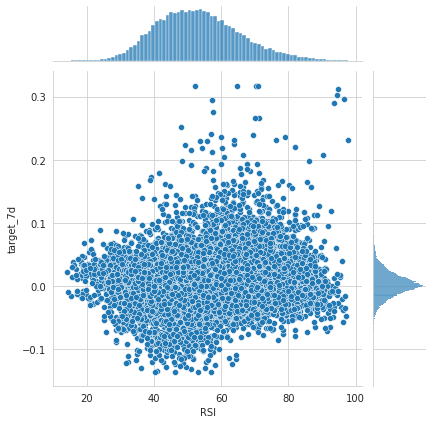

In [19]:
# Relative Strength Index (RSI)
print("Daily RETURNS FEATURE INFO")
price_copy.loc[:, 'rsi_signal'] = pd.cut(price_copy.RSI, bins=[0, 30, 70, 100])
print("RSI Distributions")
print(price_copy.groupby('rsi_signal')['target_7d'].describe().to_string())

metric = "RSI"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("RSI Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)


ADX FEATURE INFO
ADX Distributions
              count      mean       std       min       25%       50%       75%       max
adx_signal                                                                               
(0, 25]     12923.0  0.003388  0.024896 -0.135893 -0.008488  0.001962  0.013554  0.252119
(25, 50]    14019.0  0.003788  0.029997 -0.135893 -0.010527  0.001827  0.016353  0.317361
(50, 75]     2180.0  0.005733  0.036663 -0.091361 -0.015624 -0.000030  0.018752  0.296166
(75, 100]       6.0  0.003340  0.018850 -0.012991 -0.005216 -0.002053  0.001853  0.040253
ADX Spearman
-1.13% (5.47%)


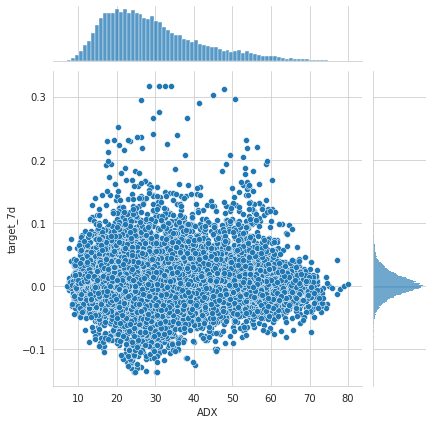

In [20]:
# Average Directional Moving Index (ADX)
print("ADX FEATURE INFO")
price_copy.loc[:, 'adx_signal'] = pd.cut(price_copy.ADX, bins=[0, 25, 50, 75, 100])
print("ADX Distributions")
print(price_copy.groupby('adx_signal')['target_7d'].describe().to_string())

metric = "ADX"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("ADX Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)



DI Plus Spearman
1.89% (0.11%)


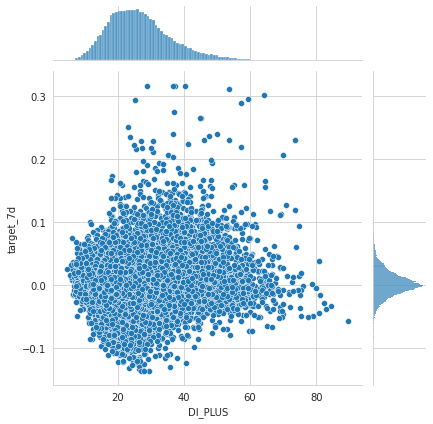

In [21]:
# Directional Indices (DM+/-)
metric = "DI_PLUS"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("DI Plus Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

DI Minus Spearman
-2.79% (0.00%)


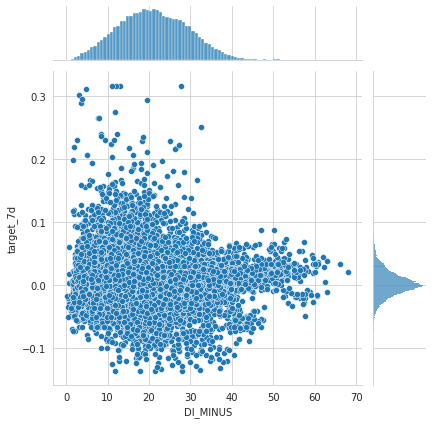

In [22]:
metric = "DI_MINUS"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("DI Minus Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

Lower BB Spearman
-3.77% (0.00%)


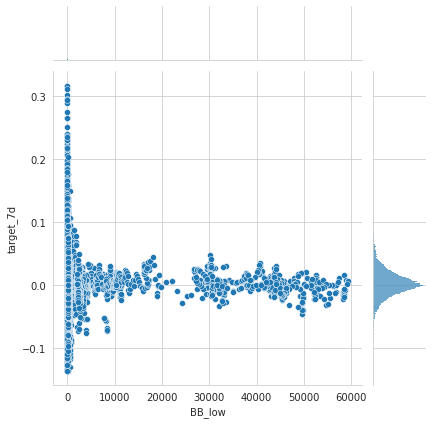

In [23]:
# Bollinger Bands
metric = 'BB_low'
df = price_copy[[metric, target]].dropna()
j=sns.jointplot(x=df[metric], y=df[target], data=df)
r, p = spearmanr(df[metric], df[target])
print("Lower BB Spearman")
print(f'{r:,.2%} ({p:.2%})')


Upper BB Spearman
-4.16% (0.00%)


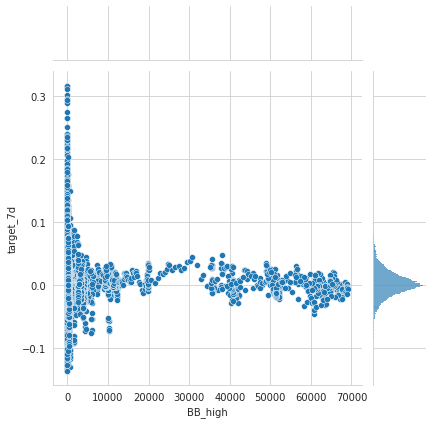

In [24]:
metric = 'BB_high'
df = price_copy[[metric, target]].dropna()
j=sns.jointplot(x=df[metric], y=df[target], data=df)
r, p = spearmanr(df[metric], df[target])
print("Upper BB Spearman")
print(f'{r:,.2%} ({p:.2%})')

ATR Spearman
-11.67% (0.00%)


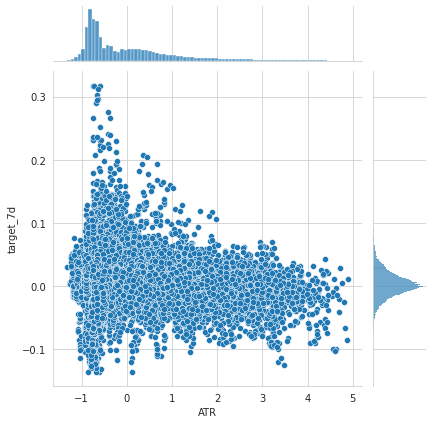

In [25]:
# Active True Range (ATR)
metric = 'ATR'
j=sns.jointplot(x=metric, y=target, data=price_copy)
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("ATR Spearman")
print(f'{r:,.2%} ({p:.2%})')

MACD Spearman
1.63% (0.55%)


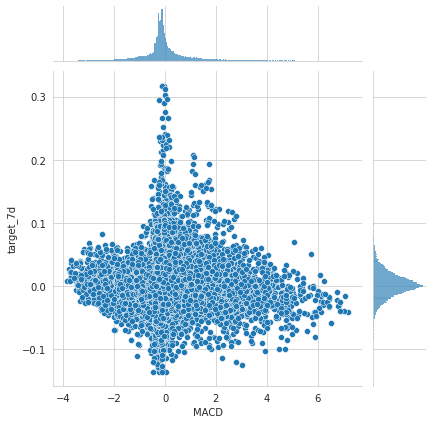

In [26]:
# Moving Average Convegeance Divergeance (MACD)
metric = 'MACD'
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("MACD Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

STOCH Spearman
0.76% (19.19%)


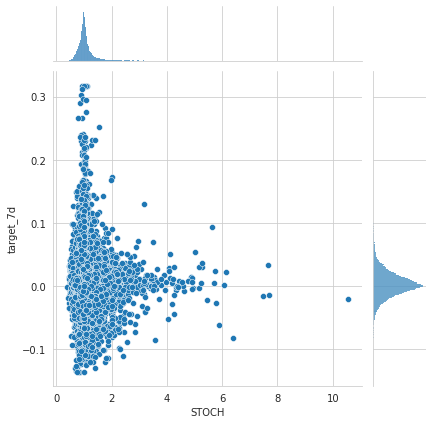

In [27]:
# Stochastic Oscillator
metric = 'STOCH'
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("STOCH Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

In [28]:
# Distribution plots and statistics
print("RETURNS PERCENTILES")
returns = prices_mdf.groupby(level='Coin').Close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
print(returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles'))

RETURNS PERCENTILES
        percentiles
std        0.089104
min       -0.522980
0.01%     -0.486122
0.1%      -0.357805
1%        -0.169270
50%        0.002056
99%        0.251630
99.9%      0.567337
99.99%     1.476733
max        7.870720


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


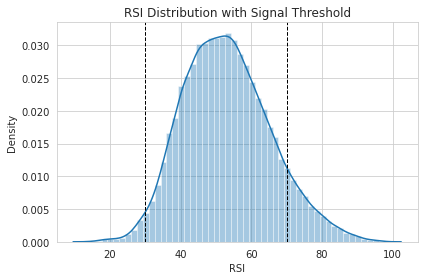

In [29]:
# RSI distplot
RSI_ax = sns.distplot(prices_mdf.RSI.dropna())
RSI_ax.axvline(30, ls='--', lw=1, c='k')
RSI_ax.axvline(70, ls='--', lw=1, c='k')
RSI_ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


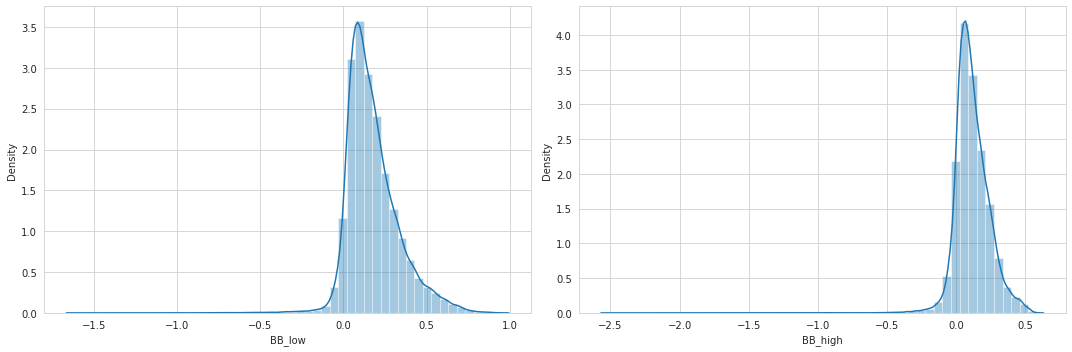

In [30]:
# Bollinger Bands distplot
prices_mdf['BB_high'] = prices_mdf.BB_high.sub(prices_mdf.Close).div(prices_mdf.BB_high).apply(np.log1p)
prices_mdf['BB_low'] = prices_mdf.Close.sub(prices_mdf.BB_low).div(prices_mdf.Close).apply(np.log1p)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices_mdf.BB_low.dropna(), ax=axes[0])
sns.distplot(prices_mdf.BB_high.dropna(), ax=axes[1])
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


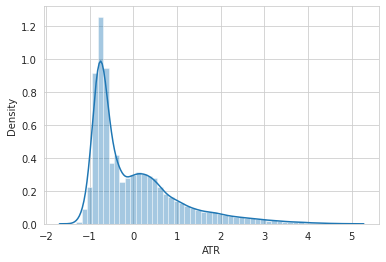

In [31]:
# Average True Range
atr_plot = sns.distplot(prices_mdf.ATR.dropna())
fig = atr_plot.get_figure()

MACD Percentiles
count    29,169.0
mean          0.0
std           1.0
min          -3.8
0.1%         -3.4
1%           -2.5
2%           -2.0
3%           -1.8
4%           -1.6
5%           -1.4
50%          -0.1
95%           1.8
96%           2.1
97%           2.4
98%           2.8
99%           3.7
99.9%         5.9
max           7.2
Name: MACD, dtype: object


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


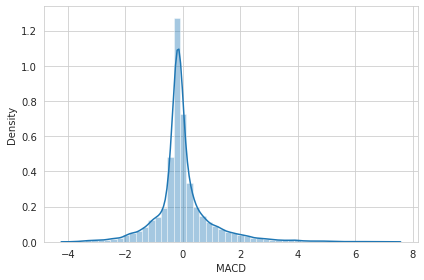

In [32]:
# MACD distribution
print("MACD Percentiles")
print(prices_mdf
      .MACD
      .describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
      .apply(lambda x: f'{x:,.1f}'))

MACD_dist = sns.distplot(prices_mdf.MACD.dropna())
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'ADX Distribution with Signal Threshold')

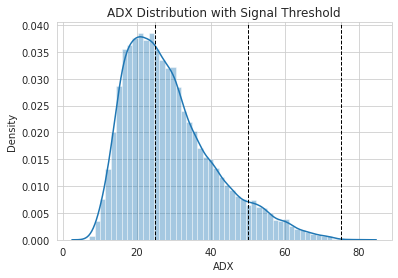

In [33]:
# ADX distribution plot
ADX_dist = sns.distplot(prices_mdf.ADX.dropna())
ADX_dist.axvline(25, ls='--', lw=1, c='k')
ADX_dist.axvline(50, ls='--', lw=1, c='k')
ADX_dist.axvline(75, ls='--', lw=1, c='k')
ADX_dist.set_title('ADX Distribution with Signal Threshold')

STOCH percentiles
count    29,825.0
mean          1.1
std           0.3
min           0.4
0.1%          0.5
1%            0.6
2%            0.6
3%            0.7
4%            0.7
5%            0.7
50%           1.0
95%           1.6
96%           1.6
97%           1.7
98%           1.9
99%           2.2
99.9%         4.4
max          10.6
Name: STOCH, dtype: object


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


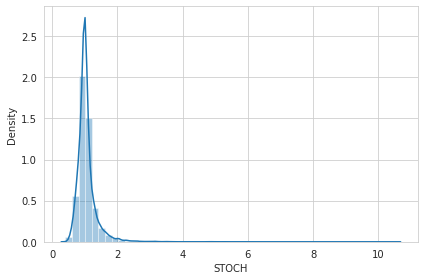

In [34]:
# Stochastic Oscillator distplot
print("STOCH percentiles")
print(prices_mdf
      .STOCH
      .describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
      .apply(lambda x: f'{x:,.1f}'))



STOCH_ax = sns.distplot(prices_mdf.STOCH.dropna())
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


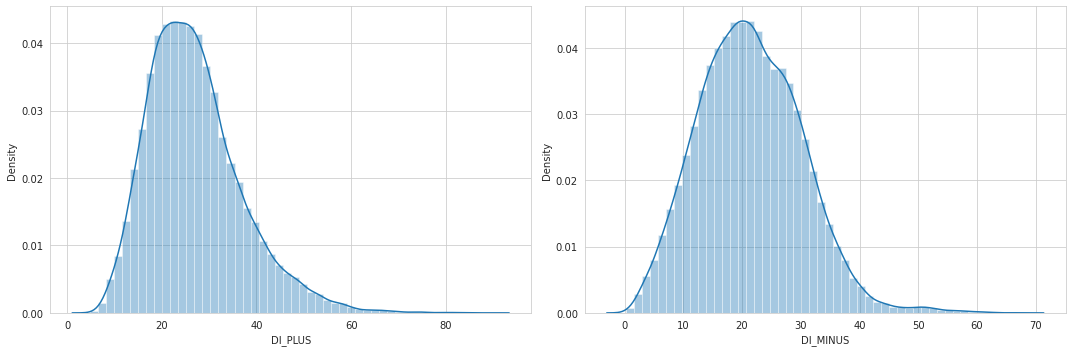

In [35]:
# Directional Indicators (DI +/-)
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices_mdf.DI_PLUS.dropna(), ax=axes[0])
sns.distplot(prices_mdf.DI_MINUS.dropna(), ax=axes[1])
plt.tight_layout()

In [36]:
prices_mdf.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'BB_high', 'BB_low',
       'ATR', 'MACD', 'STOCH', 'ADX', 'DI_PLUS', 'DI_MINUS', 'return_1d',
       'return_7d', 'return_14d', 'return_30d', 'return_60d', 'return_90d',
       'return_1d_lag1', 'return_7d_lag1', 'return_14d_lag1',
       'return_30d_lag1', 'return_60d_lag1', 'return_90d_lag1',
       'return_1d_lag2', 'return_7d_lag2', 'return_14d_lag2',
       'return_30d_lag2', 'return_60d_lag2', 'return_90d_lag2',
       'return_1d_lag3', 'return_7d_lag3', 'return_14d_lag3',
       'return_30d_lag3', 'return_60d_lag3', 'return_90d_lag3',
       'return_1d_lag4', 'return_7d_lag4', 'return_14d_lag4',
       'return_30d_lag4', 'return_60d_lag4', 'return_90d_lag4',
       'return_1d_lag5', 'return_7d_lag5', 'return_14d_lag5',
       'return_30d_lag5', 'return_60d_lag5', 'return_90d_lag5', 'target_1d',
       'target_7d', 'target_14d', 'target_30d', 'target_60d', 'target_90d',
       'year_2021', 'year_2022', 'month_2', 'month_3',

In [56]:
# Mutual Information of the Data
target_labels = [f'target_{i}d' for i in [1,7,14,30,60,90]]
targets = prices_mdf.dropna().loc[:, target_labels]

features = prices_mdf.dropna().drop(labels=target_labels, axis=1)
#print(features.columns)
cat_cols = ['year_2021','year_2022', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'BB_high', 'BB_low',
       'ATR', 'MACD', 'STOCH', 'ADX', 'DI_PLUS', 'DI_MINUS', 'return_1d',
       'return_7d', 'return_14d', 'return_30d', 'return_60d', 'return_90d',
       'return_1d_lag1', 'return_7d_lag1', 'return_14d_lag1',
       'return_30d_lag1', 'return_60d_lag1', 'return_90d_lag1',
       'return_1d_lag2', 'return_7d_lag2', 'return_14d_lag2',
       'return_30d_lag2', 'return_60d_lag2', 'return_90d_lag2',
       'return_1d_lag3', 'return_7d_lag3', 'return_14d_lag3',
       'return_30d_lag3', 'return_60d_lag3', 'return_90d_lag3',
       'return_1d_lag4', 'return_7d_lag4', 'return_14d_lag4',
       'return_30d_lag4', 'return_60d_lag4', 'return_90d_lag4',
       'return_1d_lag5', 'return_7d_lag5', 'return_14d_lag5',
       'return_30d_lag5', 'return_60d_lag5', 'return_90d_lag5', 'year_2021',
       'year_2022', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'mo

In [59]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [60]:
mutual_info.sum()

target_1d     0.197480
target_7d     0.840891
target_14d    1.227807
target_30d    1.914053
target_60d    1.947320
target_90d    2.559084
dtype: float64

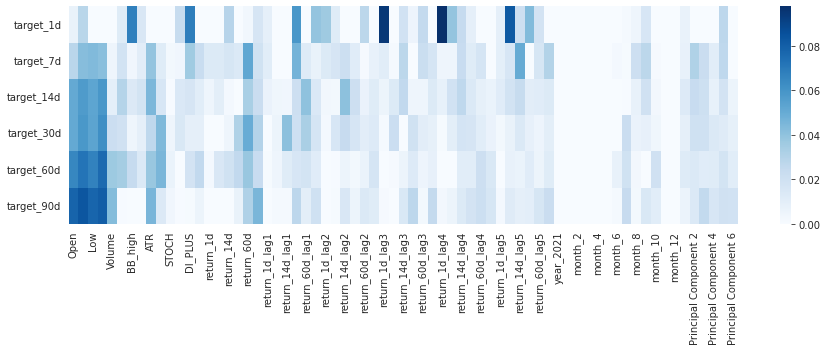

In [61]:
# Normalized Mutual Information(MI) Heatmap
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

In [65]:
prices_mdf.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'BB_high', 'BB_low',
       'ATR', 'MACD', 'STOCH', 'ADX', 'DI_PLUS', 'DI_MINUS', 'return_1d',
       'return_7d', 'return_14d', 'return_30d', 'return_60d', 'return_90d',
       'return_1d_lag1', 'return_7d_lag1', 'return_14d_lag1',
       'return_30d_lag1', 'return_60d_lag1', 'return_90d_lag1',
       'return_1d_lag2', 'return_7d_lag2', 'return_14d_lag2',
       'return_30d_lag2', 'return_60d_lag2', 'return_90d_lag2',
       'return_1d_lag3', 'return_7d_lag3', 'return_14d_lag3',
       'return_30d_lag3', 'return_60d_lag3', 'return_90d_lag3',
       'return_1d_lag4', 'return_7d_lag4', 'return_14d_lag4',
       'return_30d_lag4', 'return_60d_lag4', 'return_90d_lag4',
       'return_1d_lag5', 'return_7d_lag5', 'return_14d_lag5',
       'return_30d_lag5', 'return_60d_lag5', 'return_90d_lag5', 'target_1d',
       'target_7d', 'target_14d', 'target_30d', 'target_60d', 'target_90d',
       'year_2021', 'year_2022', 'month_2', 'month_3',

In [68]:
dummy_data = pd.get_dummies(prices_mdf,
                            columns=['year_2021', 'year_2022', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30522 entries, ('algorand', Timestamp('2020-01-01 00:00:00')) to ('zcash', Timestamp('2022-01-14 00:00:00'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   30522 non-null  float64
 1   High                   30522 non-null  float64
 2   Low                    30522 non-null  float64
 3   Close                  30522 non-null  float64
 4   Volume                 30522 non-null  float64
 5   RSI                    29948 non-null  float64
 6   BB_high                29740 non-null  float64
 7   BB_low                 29742 non-null  float64
 8   ATR                    29948 non-null  float64
 9   MACD                   29169 non-null  float64
 10  STOCH                  29825 non-null  float64
 11  ADX                    29415 non-null  float64
 12  DI_PLUS                29948 non-null  float64
 13  DI_MINUS               

In [70]:
# Dummy Data
target_labels = [f'target_{i}d' for i in [1,7,14,30,60,90]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [71]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [72]:
mutual_info_dummies.sum()

target_1d     0.201877
target_7d     0.885493
target_14d    1.265964
target_30d    1.993823
target_60d    2.043203
target_90d    2.698654
dtype: float64

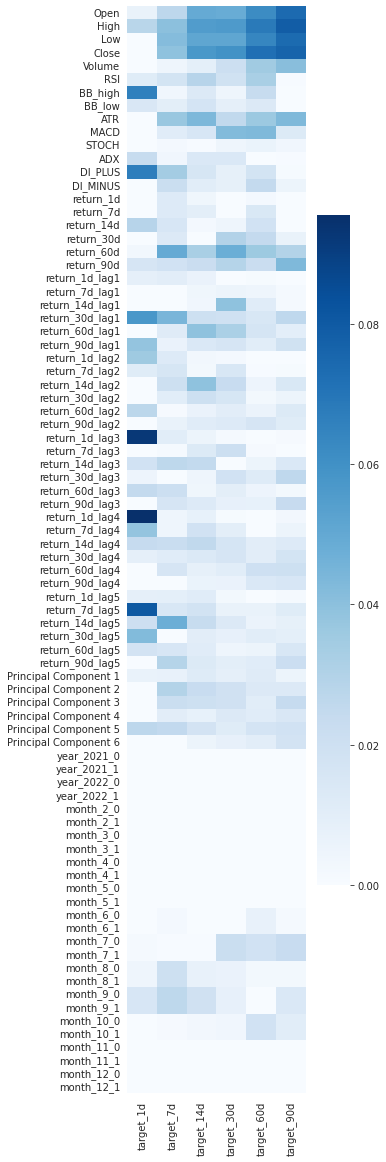

In [73]:
# Dummy Normalized Mutual Information(MI) Heatmap
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');